In [1]:
import numpy as np
from scipy.signal import convolve, convolve2d
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator as rgi
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1 import make_axes_locatable
from timeit import default_timer as tmr
from scipy.ndimage import gaussian_filter1d

In [2]:
from initial_conditions import Domain, Heaviside, LinearRamp, SmoothRamp, Sigmoid, CkRamp
from basis_functions import SVD, Trigonometric, Trigonometric2, TrigonometricOdd, Greedy, LNA, LPF, Sinc

In [3]:
#%matplotlib widget

In [4]:
dim = 2
if dim == 1:
    m, n, r = 2500, 2500, 2500
    s = 20  # steps
if dim == 2:
    s = 5
    m1, m2, n, r = 750, 750, 750,  500
#x = Domain([0, 1], m)

In [5]:
import matplotlib.pyplot as plt
import matplotlib as mpl
cmap = plt.cm.plasma
page_width_pt = 455.24
pt2in = 0.01389 
pt2cm = 0.0352777778
cm2in = 1/2.54
plot_width_in = page_width_pt*pt2in/2
print(plot_width_in/cm2in)

plt.rcParams["figure.figsize"] = (plot_width_in, plot_width_in/1.61803398875)
plt.rcParams['font.size'] = 12
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
#mpl.rc('text', usetex=True)
mpl.rc('font', family='serif', size=12, serif='Computer Modern Roman')
pth = "../Plots/"

8.030570172000001


In [6]:
def draw_brace(ax, xspan, yy, text):
    """Draws an annotated brace on the axes."""
    xmin, xmax = xspan
    xspan = xmax - xmin
    ax_xmin, ax_xmax = ax.get_xlim()
    xax_span = ax_xmax - ax_xmin

    ymin, ymax = ax.get_ylim()
    yspan = ymax - ymin
    resolution = int(xspan/xax_span*100)*2+1 # guaranteed uneven
    beta = 300./xax_span # the higher this is, the smaller the radius

    x = np.linspace(xmin, xmax, resolution)
    x_half = x[:int(resolution/2)+1]
    y_half_brace = (1/(1.+np.exp(-beta*(x_half-x_half[0])))
                    + 1/(1.+np.exp(-beta*(x_half-x_half[-1]))))
    y = np.concatenate((y_half_brace, y_half_brace[-2::-1]))
    y = yy + (.05*y - .01)*yspan # adjust vertical position

    ax.autoscale(False)
    ax.plot(x, y, color='black', lw=1)

    ax.text((xmax+xmin)/2., yy+.07*yspan, text, ha='center', va='bottom')
#

In [14]:
def plot_f(y):
    xe = np.linspace(-1, 1, 2*m+1)
    xi = (xe[1:]+xe[:-1])/2

    fig, ax = plt.subplots()
    plt.plot(xi, y, "b--")
    plt.plot(xi, y, "b.")
    plt.grid()
    #ax.add_patch(Rectangle((0, -1), 1, 2, fc="grey", ec="k", lw=3, alpha=.2))
    draw_brace(ax, (0, 1), 0.0, "")
    ax.text(.5, 0.2, r'$\Omega$', fontdict={"fontsize": 16, "ha": "center"})
    ax.text(-.4, 0.03, r'inflow', fontdict={"fontsize": 10})
    ax.annotate("", xy=(-0.0, 0.0), xytext=(-.4, 0), arrowprops=dict(arrowstyle="->"))
    ax.set_xlabel("$x$")
    ax.set_ylabel("$f(x)$")
    ax.set_ylim([-1, 1])
    #plt.show()
    return fig, ax


def plot_f_2D(y):
    fig, ax = plt.subplots()
    m, n = y.shape
    cs = ax.imshow(y[:, n//2:], extent=[0, 1, 0, 1], vmin=-1, vmax=1, zorder=1, origin="lower")
    ax.imshow(y, extent=[-1, 1, 0, 1], vmin=-1, vmax=1, zorder=1, origin="lower", alpha=.5)
    #plt.grid()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size="7.5%", pad=0.35)
    plt.colorbar(cs, orientation='horizontal', cax=cax)
    ax.add_patch(Rectangle((0, 0), 1, 1, fill=False, ec="k", lw=5, alpha=1))
    ax.text(.5, 0.5, r'$\Omega$', fontdict={"fontsize": 32, "color": "k", "ha": 'center', "va": "center"})
    ax.text(-.5, 0.53, r'inflow', fontdict={"fontsize": 10})
    ax.annotate("", xy=(0.0, 0.5), xytext=(-.5, 0.5), color="white", arrowprops=dict(arrowstyle="->"))
    #plt.show()
    return fig, ax

(10, 5) (10, 5)
(10, 5)



findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman


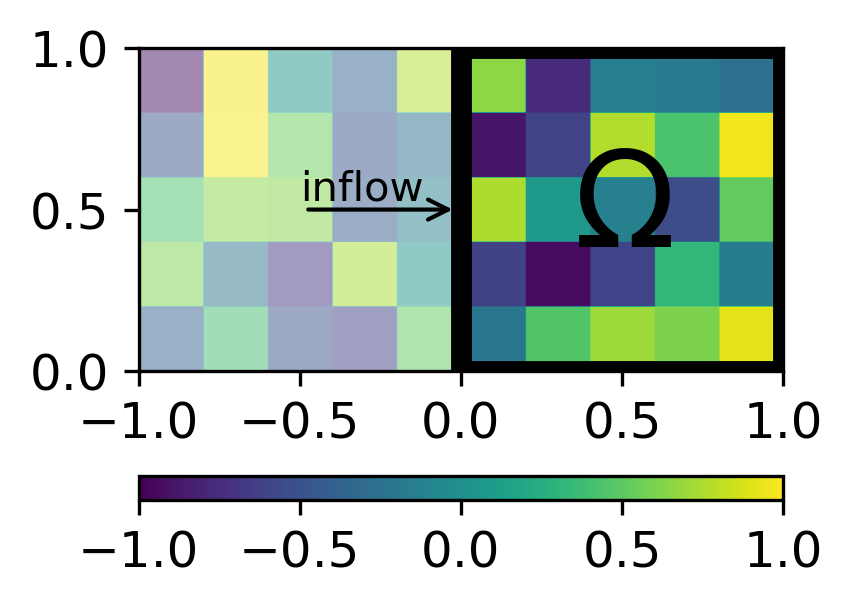

-0.9 0.1
-0.38017030930383955
-0.38017030930383955


(750, 1500)

In [8]:
def make_random_IC(s=20):
    xe = np.linspace(-1, 1, s+1)
    xm = (xe[1:]+xe[:-1])/2
    steps = np.random.rand(s,)*2-1


    interp  = rgi([xm, ], steps, method="nearest", bounds_error=False, fill_value=None)
    xe = np.linspace(-1, 1, 2*m+1)
    xi = (xe[1:]+xe[:-1])/2
    y = interp(xi)
    
    plot_f(y)
    #plt.plot(xm, steps, "ro")
    plt.show()

    return y

def make_random_IC_2D(nx=20, ny=10):
    xe = np.linspace(-1, 1, nx+1)
    xm = (xe[1:]+xe[:-1])/2
    ye = np.linspace(0, 1, ny+1)
    ym = (ye[1:]+ye[:-1])/2
    Xm, Ym = np.meshgrid(xm, ym, indexing="ij")
    steps = np.random.rand(nx, ny)*2-1
    print(Xm.shape, Ym.shape)
    print(steps.shape)
    print()

    interp  = rgi([xm, ym], steps, method="nearest", bounds_error=False, fill_value=None)
    xe = np.linspace(-1, 1, 2*m1+1)
    xi = (xe[1:]+xe[:-1])/2
    ye = np.linspace(0, 1, m2+1)
    yi = (ye[1:]+ye[:-1])/2

    #Xi, Yi = np.meshgrid(xi, yi, indexing="xy")
    #pts = np.c_[Xi.ravel(), Yi.ravel()]
    #y = interp(pts).reshape(m, 2*m)

    #Xi, Yi = np.meshgrid(xi, yi, indexing="ij")
    #pts = np.c_[Xi.ravel(), Yi.ravel()]
    #y = interp(pts).reshape(2*m, m).T

    Yi, Xi = np.meshgrid(yi, xi, indexing="ij")
    pts = np.c_[Xi.ravel(), Yi.ravel()]
    y = interp(pts).reshape(m1, 2*m2)

    plot_f_2D(y)
    #fig, ax = plt.subplots()
    #plt.scatter(Xm, Ym, c=steps, vmin=-1, vmax=1, zorder=2, edgecolors='black')
    plt.show()
    print(xm[0], ym[0])
    print(steps[0, 0])
    print(y[0, 0])
    
    return y

if dim == 1:
    
    f = make_random_IC(s=s)
if dim == 2:
    
    f = make_random_IC_2D(nx=s*2, ny=s)
f.shape


In [9]:
if dim == 1:
    X = np.zeros((m, n))
    for j in range(n):
        X[:, j] = f[(m-j):(m-j+m)]
    #plt.imshow(X, interpolation="nearest")
if dim == 2:
    X = np.zeros((m1*m2, n))
    for j in range(n):
        X[:, j] = f[:, (m2-j):(m2-j+m2)].ravel()
    #plt.imshow(X, interpolation="nearest")
print(X.shape)

(562500, 750)


In [10]:
def ddx(y, n=1):
    derivative = y
    for i in range(n):
        derivative = np.diff(derivative, prepend=0)
    return derivative

(750, 1500)
150 150
(750, 1500)
(750, 1500) (2250, 3000)
-------------------fk -0.9383092806220867 0.9836935936474882
(562500, 750) 9.424215500000173


KeyboardInterrupt: 

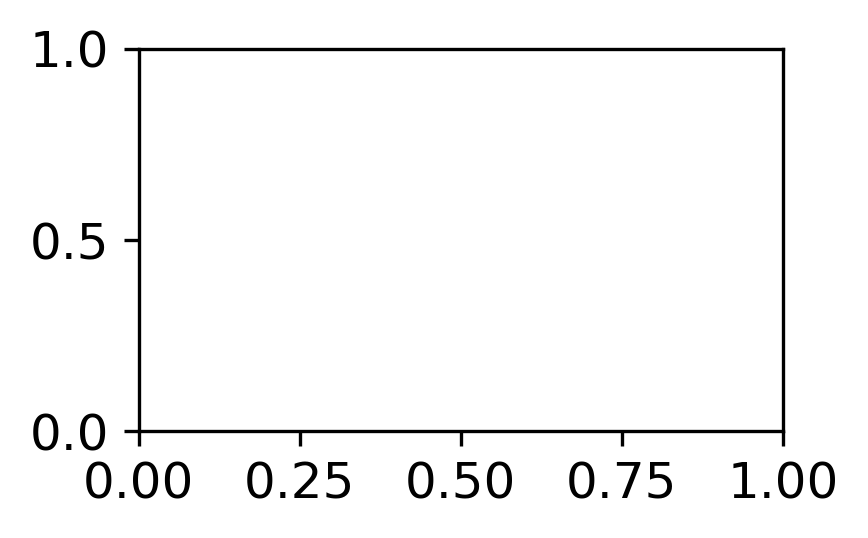

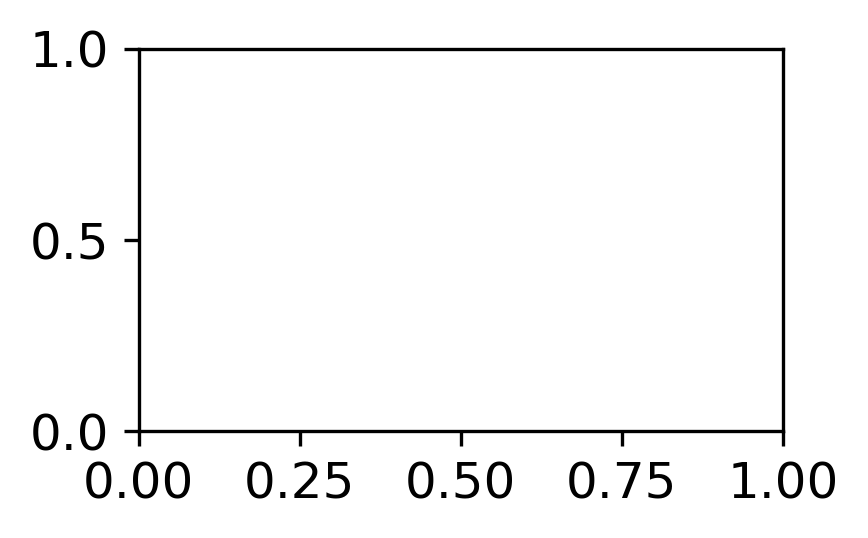

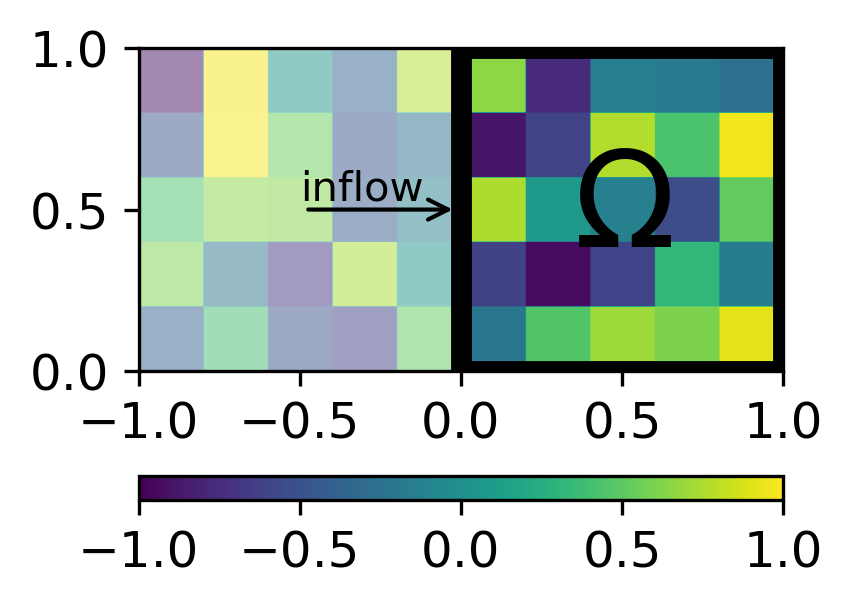

In [15]:
if dim == 1:
    p = 25
if dim == 2:
    p = 2

print(f.shape)
results = []
    
fig_dN, ax_dN = plt.subplots(tight_layout=True)
fig_d_est, ax_d_est = plt.subplots(tight_layout=True)
if dim == 1:
    kernel_width = 2*m/s  # 1%
    print(m, s, kernel_width)
    kernel_width = np.int32(kernel_width)
    print(kernel_width)
    kernel = np.ones(kernel_width) / kernel_width
#    fig, ax_fk = plot_f(fk)
    fig_fk, ax_fk = plt.subplots(tight_layout=True)
    
    xe = np.linspace(-1, 1, 2*m+1)
    xi = (xe[1:]+xe[:-1])/2
    
    n_padding = 5*kernel_width
    _fk_ = np.zeros((2*m+2*n_padding))
    _fk_[n_padding:-n_padding] = f.copy()
    
    #fk = _fk_[n_padding:-n_padding]
if dim == 2:
    w = np.int32(m1/s)
    h = np.int32(m2/s)
    print(w, h)
    print(f.shape)
    kernel = np.ones((h, w), dtype=np.float64) / (w*h)

    m_p, n_p = 5*h, 5*w
    _fk_ = np.zeros((m1+2*m_p, 2*m2+2*n_p))
    _fk_[m_p:-m_p, n_p:-n_p] = f.copy()

    #fig2, axf = plt.subplots()
    #axf.imshow(f)
    #fig_fk, ax_fk = plt.subplots(tight_layout=True)
    #ax_fk.imshow(_fk_)
print(f.shape, _fk_.shape)

for k in range(5):
    t0 = tmr()
    if k == 0:
        lbl = "disc."
    else:
        lbl = "$C^{:.0f}$".format(k-1)
    if dim == 1:
        fk = _fk_[n_padding:-n_padding]
        ax_fk.plot(xi, fk, "-", ms=1, lw=1, color=cmap(k/4), label=lbl)

        fig, ax_ddx = plt.subplots()
        ax_ddx.plot(xi, fk, ".-", ms=1, lw=1)
        derivative_N = _fk_
        for ki in range(1, k+1):
            print(k, ki)
            derivative_N = ddx(_fk_, ki)[n_padding:-n_padding]
            ax_ddx.plot(xi, derivative_N, "-", ms=1, lw=1)
        ax_ddx.set_xlim([-1, 1])
        ax_ddx.set_ylim([derivative_N.min(), derivative_N.max()])
        
        #plot_f(fk)
        Xk = np.zeros((m, n))
        for j in range(n):
            Xk[:, j] = fk[(m-j):(m-j+m)]
    if dim == 2:
        fk = _fk_[m_p:-m_p, n_p:-n_p].copy()
        print("-------------------fk", fk.min(), fk.max())
        fig_fk, ax_fk = plot_f_2D(fk)
        Xk = np.zeros((m1*m2, n))
        for j in range(n):
            Xk[:, j] = fk[:, (m2-j):(m2-j+m2)].ravel()
    t1 = tmr()
    print(Xk.shape, t1-t0)
    svd_basis = SVD(Xk)
    t2 = tmr()
    print("SVD'ed", t2-t1)
    delta_n, d_n = svd_basis.calc_error()
    t3 = tmr()
    print("calc_error'ed", t3-t2)
    results.append(delta_n)
    N = np.arange(len(delta_n))
    ax_dN.plot(N[::p], delta_n[::p], "-", color=cmap(k/4), label=lbl)
    
    k = k-1
    model = 1/np.pi**(k+2) * N**(-(2*k+3)/2)
    C = delta_n/model
    C_estimated = np.mean(C[100: r//3*2])
    print(C_estimated)
    #ax.plot(N, C_estimated*model, "k--", lw=1, ms=0)

    ax_d_est.plot(N[::p], C[::p], "-", color=cmap(k/4), label=lbl)
    ax_d_est.plot([100, r/3*2], [C_estimated, C_estimated], "k--", lw=1)
    ltex = ax_d_est.text(r/3+50, C_estimated, "c={:.1e}".format(C_estimated), size=6, color="k",
                         ha="center", va="center", bbox=dict(ec='1',fc='1', pad=0))
    ax_dN.plot(N[::p], model[::p]*C_estimated, "k--")
    ltex = ax_dN.text(r//3+50, model[r//3+50]*C_estimated, "c={:.1e}".format(C_estimated), size=6, color="k",
                         ha="center", va="center", bbox=dict(ec='1',fc='1', pad=0))
    t4 = tmr()
    print("saved", t4-t3)
    if dim == 1:
        #_fk_ = gaussian_filter1d(_fk_, 5, mode="wrap")
        _fk_ = convolve(_fk_, kernel, 'same')
    if dim == 2:
        print("-------------------_fk_", _fk_.min(), _fk_.max())
        _fk_ = convolve(_fk_, kernel, 'same')
        f_tmp, ax_tmp = plt.subplots(tight_layout=True)
        ax_tmp.imshow(_fk_)
        f_tmp, ax_tmp = plt.subplots(tight_layout=True)
        ax_tmp.plot(_fk_[(m1*3)//2, :])
        print("-------------------_fk_2", _fk_.min(), _fk_.max())
    t5 = tmr()
    print("convolved", t5-t4)

if dim==1:
    ax_fk.grid(which="both")
    #ax.add_patch(Rectangle((0, -1), 1, 2, fc="grey", ec="k", lw=3, alpha=.2))
    draw_brace(ax_fk, (0, 1), 0.0, "")
    ax_fk.text(.5, 0.2, r'$\Omega$', fontdict={"fontsize": 16, "ha": "center"})
    ax_fk.text(-.4, 0.03, r'inflow', fontdict={"fontsize": 10})
    ax_fk.annotate("", xy=(-0.0, 0.0), xytext=(-.4, 0), arrowprops=dict(arrowstyle="->"))
    ax_fk.set_xlabel("$x$")
    ax_fk.set_ylabel("$q(x)$")
    ax_fk.set_xlim([-1, 1])
    ax_fk.set_ylim([-1, 1])
    ax_fk.legend(prop={'size': 6})

ax_dN.set_ylim([1e-12, 1e+0])
ax_dN.set_xlim([0, r]) 
ax_dN.set_yscale('log')
ax_dN.legend(prop={'size': 6})
ax_dN.set_xlabel(r'$N$')
ax_dN.set_ylabel(r'$\delta_N$')
ax_dN.grid(which="both")


plt.tight_layout()

ax_d_est.legend(prop={'size': 6})
ax_d_est.set_yscale('log')
ax_d_est.set_xlim([0, r])
#ax_d_est.set_ylim([0, 10])
ax_d_est.set_xlabel(r'$N$')
ax_d_est.set_ylabel(r'$c$')

fig_dN.savefig(pth+"random_"+str(dim)+"D_decay.pdf")
fig_fk.savefig(pth+"randomIC_"+str(dim)+"D.pdf")
plt.show()

In [16]:
fig_fk.savefig(pth+"randomIC_"+str(dim)+"D.pdf")

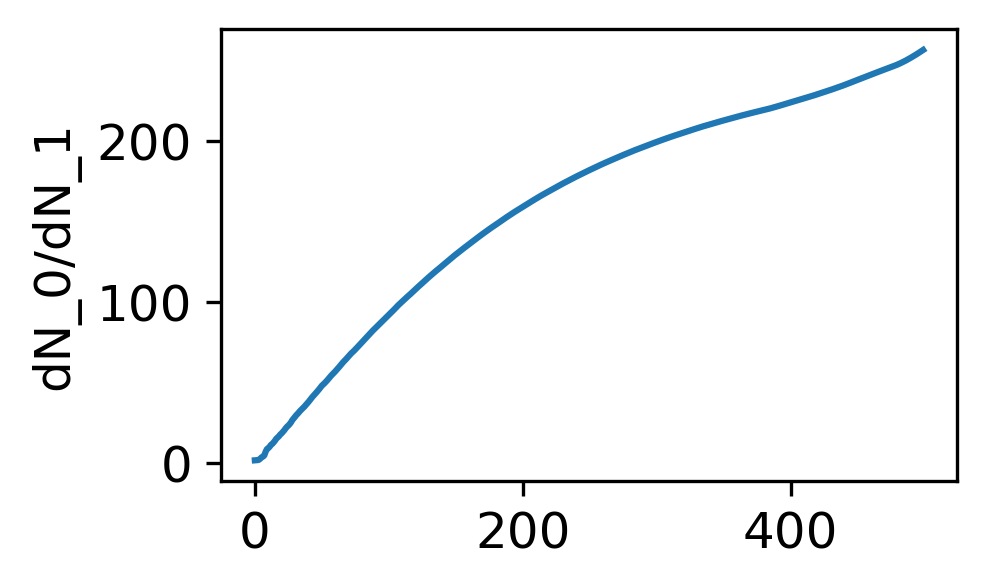

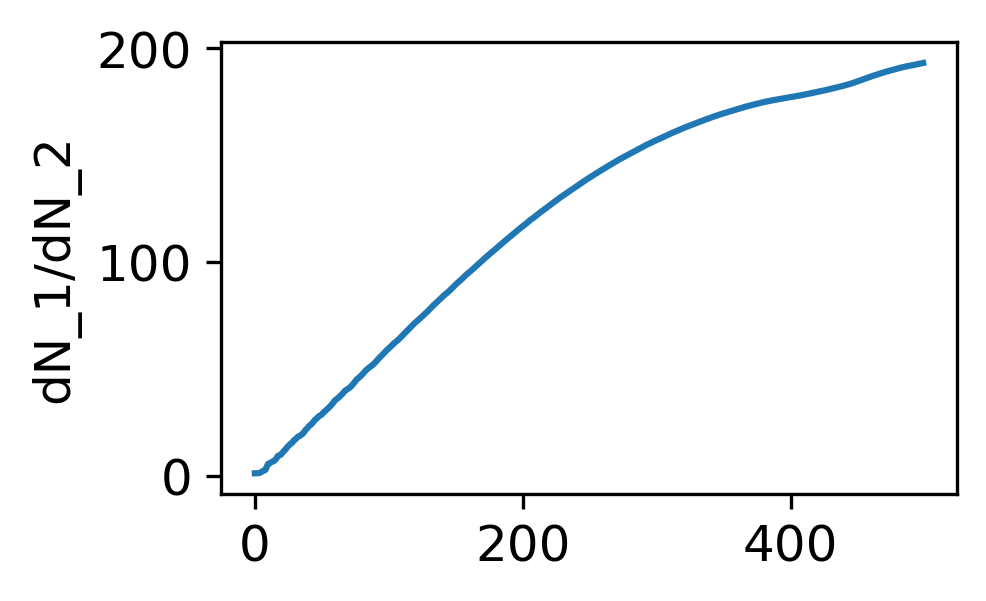

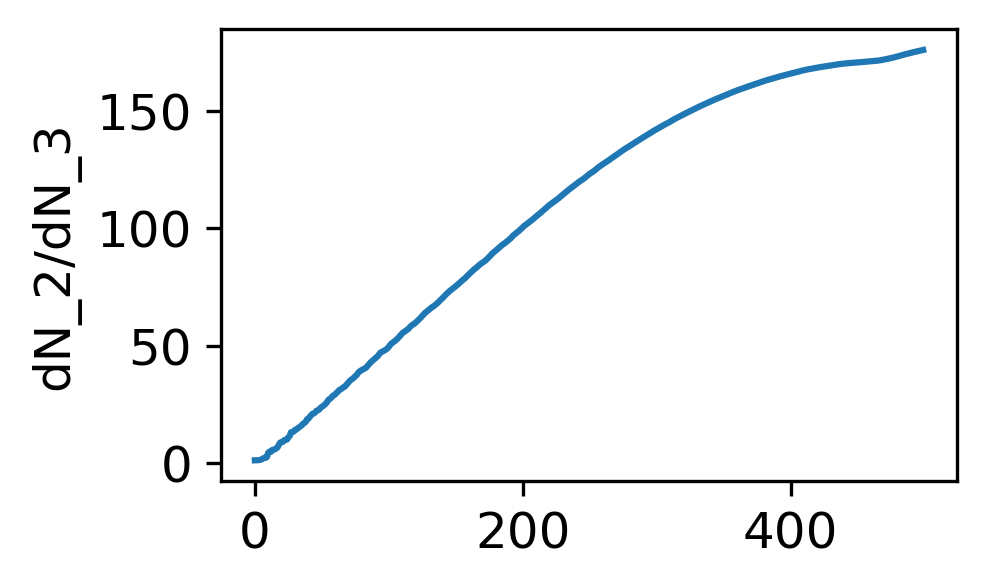

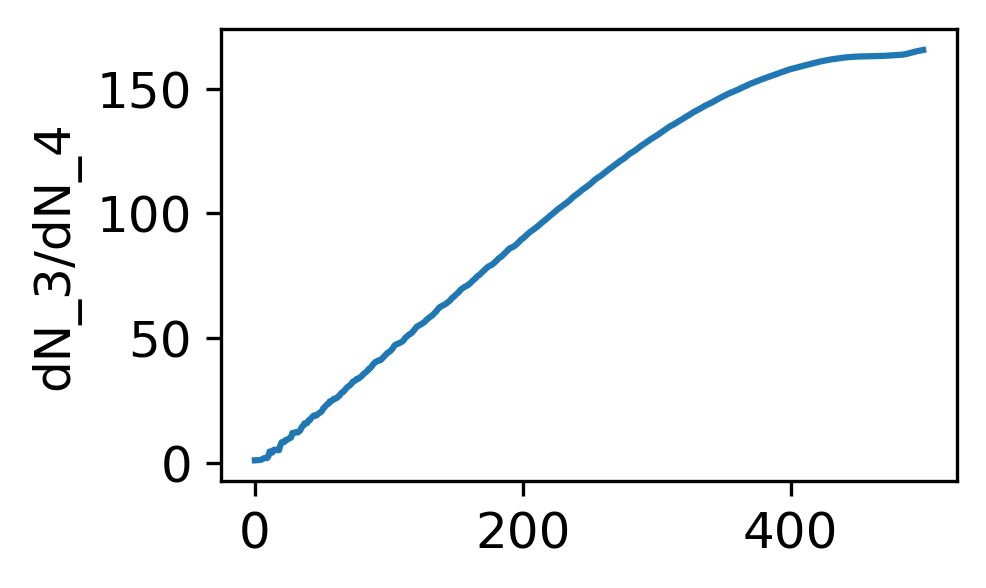

In [12]:
N = np.arange(r)
for i in range(4):
    fig, ax = plt.subplots()
    plt.plot(N, (results[i]/results[i+1])[N])
    #plt.xlim(0, 750)
    #plt.ylim(0, 25)
    plt.ylabel("dN_{:.0f}/dN_{:.0f}".format(i, i+1))
    plt.show()


NameError: name 'm' is not defined

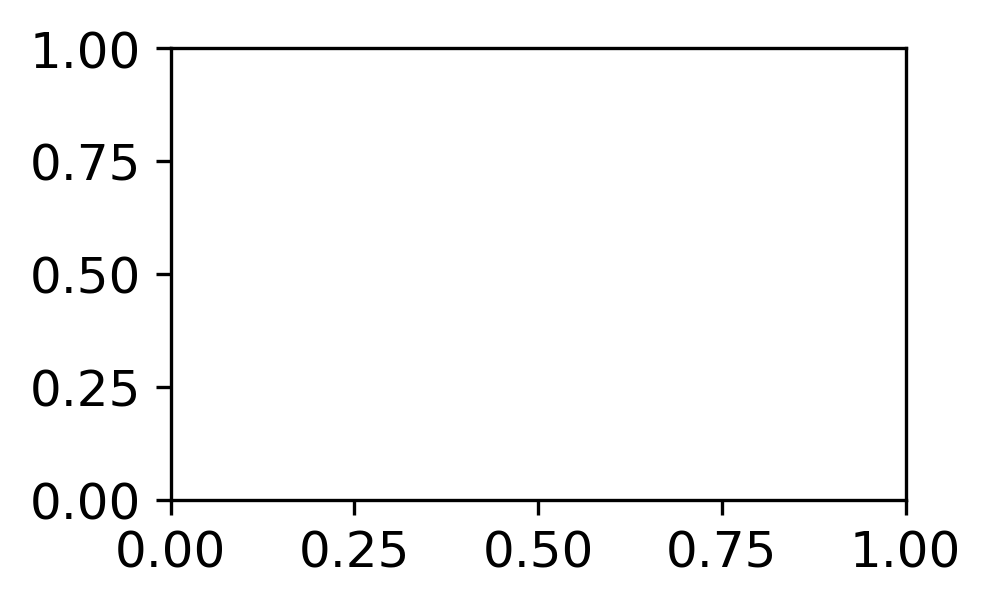

In [13]:
fig, ax = plt.subplots()
for i in range(6):
    ax.plot(np.linspace(0, 1, m), svd_basis.U[:, i])
ax.set_xlabel("x")
plt.show()

filter width: at least max distance between discontinuities
